In [1]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [2]:
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
import torch
import gpytorch

In [4]:
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [6]:
import Di

In [7]:
df = pd.read_csv("96ghpptzvf-4/SData2/CoCl2_geno.txt", sep='\t', nrows=5, engine='python')

In [8]:
ids = list(df.columns[3:])

In [9]:
geno_t = torch.load('matsui_geno_t.pt')

In [10]:
geno_t

tensor([[1., 2., 2.,  ..., 0., 0., 0.],
        [1., 2., 2.,  ..., 0., 0., 0.],
        [1., 2., 2.,  ..., 0., 0., 0.],
        ...,
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)

In [11]:
geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

In [12]:
pheno = pd.read_csv("96ghpptzvf-4/SData6/CoCl2_pheno.txt", sep='\t', engine="python")

In [13]:
pheno.head()

,pheno,MATa,MATalpha,geno,qnorm,MATa_mid,MATalpha_mid,midparent
0,-0.021705,y39_A012,BYa_1C_A10,BYa_1C_A10.y39_A012,-0.021147,0.074002,-0.336769,-0.131384
1,-0.184045,y39_A02,BYa_1C_A10,BYa_1C_A10.y39_A02,-0.924553,-0.286352,-0.336769,-0.311561
2,-0.133887,y39_A03,BYa_1C_A10,BYa_1C_A10.y39_A03,-0.640047,-0.896266,-0.336769,-0.616517
3,-0.021991,y39_A04,BYa_1C_A10,BYa_1C_A10.y39_A04,-0.022688,0.593958,-0.336769,0.128595
4,0.088438,y39_A05,BYa_1C_A10,BYa_1C_A10.y39_A05,0.574957,0.576434,-0.336769,0.119833


In [14]:
pheno = pheno.set_index('geno')

In [15]:
pheno = pheno.loc[ids]

### Test Parallel

In [16]:
sub = np.random.choice(range(N), 10000)

In [17]:
sub_t = np.random.choice(list(set(range(N)).difference(sub)), 1000)

In [18]:
train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]))

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]))

In [19]:
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

output_device = torch.device('cuda:0')

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

In [20]:
output_device = torch.device('cuda:0')

In [21]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 8 GPUs.


In [22]:
def d(geno1, geno2):
  """build distance tensor between two sets of genotypes
  geno1, geno2: n x L, m x L torch tensors
  
  """
  geno1_h0 = 1.*(geno1 == 0.)
  geno1_h1 = 1.*(geno1 == 2.)
  geno2_h0 = 1.*(geno2 == 0.)
  geno2_h1 = 1.*(geno2 == 2.)
  S1 = torch.matmul(geno1%2, torch.transpose(geno2%2, 0, 1))
  S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
  D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
  D1 = L - S1 - S2 - D2

  return torch.stack((S1, S2, D1, D2))


In [23]:
def k(log_lda, log_eta, dvec):
    """
    log_lda, log_eta -- torch tensors
    dvec -- 4 x n x m torch tensor
    """
    lda = torch.exp(log_lda)
    eta = torch.exp(log_eta)
    return (((1 + lda + eta)**(dvec[1] - L/2))
          *((1 - lda + eta)**dvec[3])
          *((1 + eta)**(dvec[0] - L/2)) 
          * (1-eta)**dvec[2])


In [24]:
from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan

class DiKernel(gpytorch.kernels.Kernel):
  """Diploid kernel"""

  is_stationary = True

  # We will register the parameter when initializing the kernel
  def __init__(self, 
                lda_prior=None, lda_constraint=None, 
                eta_prior=None, eta_constraint=None,
                **kwargs):
      super().__init__(**kwargs)

      # register the raw parameter
      self.register_parameter(
          name='raw_lda', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      self.register_parameter(
          name='raw_eta', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      # set the parameter constraint to be positive, when nothing is specified
      if lda_constraint is None:
          lda_constraint = LessThan(upper_bound=0.)

      if eta_constraint is None:
          eta_constraint = LessThan(upper_bound=0.)

      # register the constraint
      self.register_constraint("raw_lda", lda_constraint)
      self.register_constraint("raw_eta", eta_constraint)

      
  # now set up the 'actual' paramter
  @property
  def lda(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_lda_constraint.transform(self.raw_lda)

  @property
  def eta(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_eta_constraint.transform(self.raw_eta)

  @lda.setter
  def lda(self, value):
      return self._set_lda(value)

  @eta.setter
  def eta(self, value):
      return self._set_eta(value)

  def forward(self, x1, x2, **params):
    diff = d(x1, x2)
    return k(lda, eta, diff)
#     return k(self.lda, self.eta, diff)
#     return self.eta*diff[0]
#     dvec = diff
#     log_lda = torch.nn.Parameter(torch.tensor(-8.))
#     log_eta = torch.nn.Parameter(torch.tensor(-12.))
#     lda = torch.exp(log_lda)
#     eta = torch.exp(log_eta)
    
#     return (((1 + lda + eta)**(dvec[1] - L/2))
#     *((1 - lda + eta)**dvec[3])
#     *((1 + eta)**(dvec[0] - L/2)) 
#     * (1-eta)**dvec[2])



In [25]:
lda = torch.nn.Parameter(torch.tensor(-8.))
eta = torch.nn.Parameter(torch.tensor(-12.))

In [26]:
class DiGPModel(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            DiKernel(), device_ids=range(n_devices),
            output_device=output_device
        )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [27]:
# class DiGPModel(gpytorch.models.ExactGP):

#   def __init__(self, train_x, train_y, likelihood):
#     super().__init__(train_x, train_y, likelihood)
#     self.mean_module = gpytorch.means.ConstantMean()
#     self.covar_module = DiKernel()

#   def forward(self, x):
#     mean_x = self.mean_module(x)
#     covar_x = self.covar_module(x)
#     return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [28]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = DiGPModel(train_x, train_y, likelihood)
model = model.double().to(output_device)

In [29]:
model.covar_module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))

In [30]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [31]:
test_x = test_x.cuda()

In [32]:
model.eval()
f_preds = model(test_x)

In [33]:
f_mean = f_preds.mean.cpu()

In [39]:
f_true = test_y.cpu().numpy()

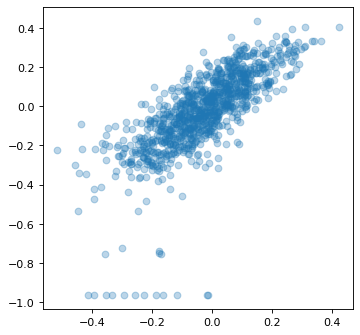

r2 = 0.562531
R2 = 0.559035
mse = 0.018176


In [40]:
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), f_true, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), f_true)[0]**2)
print('R2 = %f'%r2(f_true, f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), f_true))

In [41]:
optimizer = torch.optim.AdamW([
    {'params': model.parameters()},
    {'params': lda},
    {'params': eta}
], lr = .05)

In [42]:
output = model(train_x)

/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [43]:
loss = -mll(output, train_y)

/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


In [44]:
loss.backward()

In [ ]:
optimizer.step()

In [ ]:
lda

In [54]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model.train()
likelihood.train()

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},
    {'params': lda},
    {'params': eta}
], lr = .05)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

losses = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


In [55]:
output = model(train_x)


In [58]:
output

MultivariateNormal(loc: torch.Size([10000]))

In [56]:
loss = -mll(output, train_y)

RuntimeError: Found dtype Float but expected Double

In [49]:
def train(model,
          train_x,
          train_y,
          n_devices,
          output_device,
          n_training_iter,
          lr
):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
    model.train()
    likelihood.train()

    optimizer = torch.optim.AdamW([
        {'params': model.parameters()},
        {'params': lda},
        {'params': eta}
    ], lr = .05)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    losses = []

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(n_training_iter):
      if i%20==0:
        print(i)
      else: pass
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(train_x)
      # Calc loss and backprop gradients
      loss = -mll(output, train_y)
      loss.backward()
      losses.append(loss.item())    
      optimizer.step()
      del loss
    return losses
    
    
    


#     with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
#          gpytorch.settings.max_preconditioner_size(preconditioner_size):

#         def closure():
#             optimizer.zero_grad()
#             output = model(train_x)
#             loss = -mll(output, train_y)
#             return loss

#         loss = closure()
#         loss.backward()

#         for i in range(n_training_iter):
#             options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
#             loss, _, _, _, _, _, _, fail = optimizer.step(options)

#             print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#                 i + 1, n_training_iter, loss.item(),
#                 model.covar_module.module.base_kernel.lengthscale.item(),
#                 model.likelihood.noise.item()
#             ))

#             if fail:
#                 print('Convergence reached!')
#                 break

#     print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
#     return model, likelihood

In [50]:
losses = train(model,
    train_x,
    train_y,
    n_devices,
    output_device,
    n_training_iter=100,
    lr=.05
)

0


RuntimeError: Found dtype Float but expected Double

In [93]:
import gc

def find_best_gpu_setting(train_x,
                          train_y,
                          n_devices,
                          output_device,
                          preconditioner_size
):
    N = train_x.size(0)

    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            _, _ = train(model, train_x, train_y,
                         n_devices=n_devices, output_device=output_device,
                         checkpoint_size=checkpoint_size,
                         preconditioner_size=preconditioner_size, n_training_iter=1, lr=0.05)

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size

# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(train_x, train_y,
                                        n_devices=n_devices,
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)

Number of devices: 4 -- Kernel partition size: 0
RuntimeError: Found dtype Float but expected Double


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/lazy/added_diag_lazy_tensor.py:102: NumericalWarning: NaNs encountered in preconditioner computation. Attempting to continue without preconditioning.
  warnings.warn(


Number of devices: 4 -- Kernel partition size: 5000
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 10000])
Number of devices: 4 -- Kernel partition size: 2500
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 10000])
Number of devices: 4 -- Kernel partition size: 1250
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 10000])
Number of devices: 4 -- Kernel partition size: 625
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 10000])
Number of devices: 4 -- Kernel partition size: 313
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 